In [22]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tqdm
import optuna
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [23]:
# read data

train = pd.read_csv('train_df.csv')
test = pd.read_csv('test_df.csv')

In [24]:
# standardscaler

features = ['TYPE', 'BUILD_YEAR', 'GROSS_TONNAGE', 'SUMMER_DEADWEIGHT', 'LENGTH',
       'EFFICIENCY_VALUE', 'EFFICIENCY_TYPE_Applicable',
       'EFFICIENCY_TYPE_EEDI', 'EFFICIENCY_TYPE_EIV']
target = 'EMISSION'

train, test = train.align(test, join='left', axis=1, fill_value=0)
X = train[features]
y = train[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

test = test[features]
test = scaler.transform(test)

[I 2025-02-07 13:46:56,783] A new study created in memory with name: no-name-77660443-c733-47d7-b9be-2464b9ddaf0d
[I 2025-02-07 13:46:57,121] Trial 0 finished with value: 0.0646263660369174 and parameters: {'iterations': 285, 'learning_rate': 0.00021468956580247825, 'depth': 8, 'l2_leaf_reg': 0.20487750296103335, 'border_count': 64, 'bagging_temperature': 0.08452383925723361, 'random_strength': 0.7418269646828693, 'one_hot_max_size': 7}. Best is trial 0 with value: 0.0646263660369174.
[I 2025-02-07 13:46:57,367] Trial 1 finished with value: 0.3419349503864678 and parameters: {'iterations': 317, 'learning_rate': 0.002921105533612468, 'depth': 5, 'l2_leaf_reg': 0.14413947040147387, 'border_count': 225, 'bagging_temperature': 0.08243329838480384, 'random_strength': 0.006026521309027033, 'one_hot_max_size': 10}. Best is trial 1 with value: 0.3419349503864678.
[I 2025-02-07 13:46:57,567] Trial 2 finished with value: 0.22168783507403478 and parameters: {'iterations': 399, 'learning_rate': 0.

Best trial:
  Value: 0.6241995507896335
  Params: 
    iterations: 634
    learning_rate: 0.015309468403633607
    depth: 8
    l2_leaf_reg: 7.990331205508949
    border_count: 142
    bagging_temperature: 0.2167391431061595
    random_strength: 0.6101619532480151
    one_hot_max_size: 7


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 518.0739502	test: 233.6907757	best: 233.6907757 (0)	total: 1.58ms	remaining: 999ms
1:	learn: 516.9648136	test: 231.6465013	best: 231.6465013 (1)	total: 3.04ms	remaining: 962ms
2:	learn: 515.8974320	test: 229.7677032	best: 229.7677032 (2)	total: 4.77ms	remaining: 1s
3:	learn: 514.5076990	test: 227.6685515	best: 227.6685515 (3)	total: 6.27ms	remaining: 988ms
4:	learn: 513.5276435	test: 225.8216468	best: 225.8216468 (4)	total: 7.8ms	remaining: 981ms
5:	learn: 512.5431953	test: 224.0088116	best: 224.0088116 (5)	total: 9.52ms	remaining: 996ms
6:	learn: 511.5953222	test: 222.3144232	best: 222.3144232 (6)	total: 11ms	remaining: 983ms
7:	learn: 510.7149833	test: 220.5929011	best: 220.5929011 (7)	total: 12.8ms	remaining: 1s
8:	learn: 509.7576627	test: 218.7916824	best: 218.7916824 (8)	total: 14.6ms	remaining: 1.01s
9:	learn: 508.8696633	test: 217.0843729	best: 217.0843729 (9)	total: 17.4ms	remaining: 1.08s
10:	learn: 507.9774717	test: 215.4298779	best: 215.4298779 (10)	total: 18.7ms	r

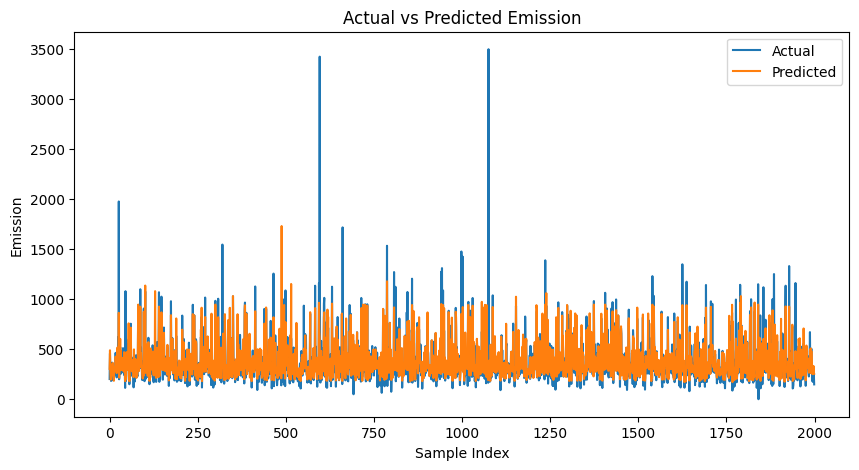

In [25]:
# catboost

train_pool = Pool(data=X_train, label=y_train)
test_pool = Pool(data=X_test, label=y_test)

def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),  
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1), 
        'depth': trial.suggest_int('depth', 4, 10),  
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10),  
        'border_count': trial.suggest_int('border_count', 32, 255),  
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),  
        'random_strength': trial.suggest_float('random_strength', 0.0, 1.0),  
        'one_hot_max_size': trial.suggest_int('one_hot_max_size', 2, 10),  
        'eval_metric': 'RMSE', 
        'random_seed': 42,  
        'logging_level': 'Silent',  
        'early_stopping_rounds': 100  
    }

    catboost_model = CatBoostRegressor(**param)
    catboost_model.fit(train_pool, eval_set=test_pool, verbose=0)

    y_pred = catboost_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    return r2

study = optuna.create_study(direction='maximize')  
study.optimize(objective, n_trials=100, timeout=600)  

print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

best_params = trial.params
catboost_model = CatBoostRegressor(**best_params, random_seed=42)
catboost_model.fit(train_pool, eval_set=test_pool, plot=True)

y_pred = catboost_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))

print(f'Best R² Score: {r2:.4f}')
print(f'Best RMSE:{rmse:.4f}')

plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Emission')
plt.title('Actual vs Predicted Emission')
plt.show()

In [26]:
# predict

predict = catboost_model.predict(test)

submit = pd.read_csv('example-submission.csv', skiprows=1, header=None)
submit[1] = predict
submit.to_csv('result.csv', header=None, index=False)

print('Prediction completed.')

Prediction completed.
